In [47]:
%cd E:\Github\Product_classifier\Notebooks\fashion_classifier

E:\Github\Product_classifier\Notebooks\fashion_classifier


# Loading our dataset

In [48]:
from datasets import load_dataset
fashion = load_dataset("fashion_mnist", split="train[:10000]")


In [49]:
import numpy as np
# Get the first example
first_example = next(iter(fashion))

# Print available features
print("Features:", fashion.features)

# Convert PIL Image to numpy array and print shape
print("Image shape:", np.array(first_example['image']).shape)

# Print the label
print("Label:", first_example['label'])

Features: {'image': Image(mode=None, decode=True, id=None), 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}
Image shape: (28, 28)
Label: 9


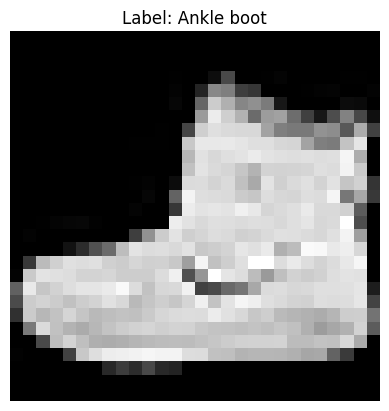

In [50]:
import matplotlib.pyplot as plt

plt.imshow(first_example['image'], cmap='gray')
plt.axis('off')
plt.title(f"Label: {fashion.features['label'].names[first_example['label']]}")
plt.show()


## Previewing the data we've obtained

In [51]:
# Create a dictionary to store all data
fashion_dict = {
    'images': [],
    'labels': [],
    'label_names': fashion.features['label'].names
}

# Convert streaming dataset to dictionary
for example in fashion:
    fashion_dict['images'].append(np.array(example['image']))
    fashion_dict['labels'].append(example['label'])

# Convert lists to numpy arrays for better handling
fashion_dict['images'] = np.array(fashion_dict['images'])
fashion_dict['labels'] = np.array(fashion_dict['labels'])

# Print the structure of our dictionary
print("Dictionary structure:")
print(f"- Images shape: {fashion_dict['images'].shape}")
print(f"- Labels shape: {fashion_dict['labels'].shape}")
print(f"- Label names: {fashion_dict['label_names']}")

Dictionary structure:
- Images shape: (10000, 28, 28)
- Labels shape: (10000,)
- Label names: ['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


## Splitting our data into train and test sets

In [52]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    fashion_dict['images'], 
    fashion_dict['labels'],
    test_size=0.2, 
    random_state=42  
)

# Create a dictionary to store the split data
fashion_splitted = {
    'train': {
        'images': X_train,
        'labels': y_train
    },
    'test': {
        'images': X_test,
        'labels': y_test
    },
    'label_names': fashion_dict['label_names']
}

# Print the shapes to verify the split
print("Training set shape:", fashion_splitted['train']['images'].shape)
print("Testing set shape:", fashion_splitted['test']['images'].shape)

Training set shape: (8000, 28, 28)
Testing set shape: (2000, 28, 28)


In [53]:
fashion_splitted

{'train': {'images': array([[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],
  
         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],
  
         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],
  
         ...,
  
         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],
  
         [[0, 0, 0, ..., 0, 0, 0],
          [0,

## Identifying the labels in correlation to its ID and vice versa

In [54]:
labels = fashion_splitted["label_names"]
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [55]:
id2label

{'0': 'T - shirt / top',
 '1': 'Trouser',
 '2': 'Pullover',
 '3': 'Dress',
 '4': 'Coat',
 '5': 'Sandal',
 '6': 'Shirt',
 '7': 'Sneaker',
 '8': 'Bag',
 '9': 'Ankle boot'}

# Identifying the image processor 

In [56]:
from transformers import ViTImageProcessor, ViTModel

# Initialize the feature extractor with size handling
processor = ViTImageProcessor.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    size=224,  # target size
    do_resize=True,  # enable resizing
    resample=3,  # bicubic interpolation
    use_fast = True
)

In [57]:
processor.size

size = (processor.size['height'], processor.size['width'])
size

(224, 224)

## Augementing our images with the properties set in our processor

In [58]:
from torchvision.transforms import RandomResizedCrop, Compose, ToTensor, Normalize

transform = Compose([
    RandomResizedCrop(size),
    ToTensor(),
    Normalize(mean=processor.image_mean, std=processor.image_std)
])

### Preprocessing our images and deleting the original image files

In [59]:
def preprocess_images(samples):
    # Convert grayscale to RGB by stacking the same channel 3 times
    # Reshape to add channel dimension if needed
    if len(samples.shape) == 3:
        samples = samples[:, :, :, None]  # Add channel dimension if not present
    rgb_samples = np.repeat(samples, 3, axis=3)  # Convert to RGB by repeating channel
    
    # Process the images using the ViT processor
    processed = processor(
        images=rgb_samples,  # Pass the RGB numpy array
        return_tensors="pt",
        padding=True
    )
    return processed['pixel_values']


In [60]:
# Apply the preprocessing
fashion_splitted_trans = {
    'train': {
        'images': preprocess_images(fashion_splitted['train']['images']),
        'labels': fashion_splitted['train']['labels']
    },
    'test': {
        'images': preprocess_images(fashion_splitted['test']['images']),
        'labels': fashion_splitted['test']['labels']
    },
    'label_names': fashion_splitted['label_names']
}

e:\Anaconda\envs\product_classifier\Lib\site-packages\transformers\image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)


In [61]:
fashion_splitted_trans['train']['images'][0]

tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]])

# Importing our model for image classification

In [62]:
from transformers import AutoModelForImageClassification, Trainer, TrainingArguments

model = AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=10,
    id2label=id2label,
    label2id=label2id,
)

model.config.problem_type = "single_label_classification"

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Identifying the data collator (Data Loader)

In [63]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

## Identifying the evaulation metrics for the model

In [64]:
import evaluate 
import numpy as np

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

## Identifying the training arguments, number of epochs, batch size, learning rate, and other hyperparameters for training the model.

### Identifying the data trainer using our model, training arguments, data loader, evaulation metrics, our datasets and images processor.

In [65]:
import torch
from torch.utils.data import Dataset as TorchDataset

class FashionTorchDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'pixel_values': self.images[idx],  
            'label': int(self.labels[idx])    
        }


# Use this for Trainer
train_dataset = FashionTorchDataset(fashion_splitted_trans['train']['images'], fashion_splitted_trans['train']['labels'])
eval_dataset = FashionTorchDataset(fashion_splitted_trans['test']['images'], fashion_splitted_trans['test']['labels'])


In [66]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    remove_unused_columns=False,
    num_train_epochs=8,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    learning_rate=1e-4,
    per_device_eval_batch_size=16,   # batch size for evaluation
    weight_decay=0.01,               # strength of weight decay
    save_strategy='epoch',
    logging_steps=50,
    push_to_hub=False,
    metric_for_best_model='accuracy',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor
)


C:\Users\maraw\AppData\Local\Temp\ipykernel_21148\138711776.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


# Model Training

In [67]:
print("Model's expected loss function:", model.config.problem_type)
print("Number of labels:", model.config.num_labels)


Model's expected loss function: single_label_classification
Number of labels: 10


In [68]:
trainer.train()

Step,Training Loss
50,1.448400
100,0.730900
150,0.587000
200,0.501500
250,0.463200
300,0.402600
350,0.348500
400,0.402200
450,0.374900
500,0.339200


TrainOutput(global_step=4000, training_loss=0.1340591098740697, metrics={'train_runtime': 1376.4915, 'train_samples_per_second': 46.495, 'train_steps_per_second': 2.906, 'total_flos': 4.959842937864192e+18, 'train_loss': 0.1340591098740697, 'epoch': 8.0})

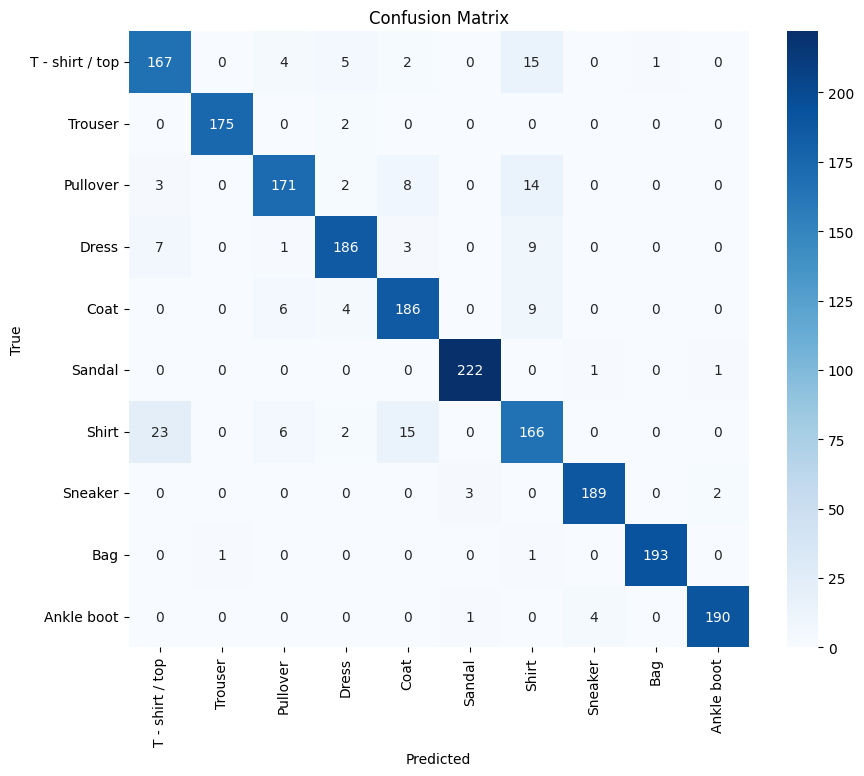

Classification Report:
                 precision    recall  f1-score   support

T - shirt / top       0.83      0.86      0.85       194
        Trouser       0.99      0.99      0.99       177
       Pullover       0.91      0.86      0.89       198
          Dress       0.93      0.90      0.91       206
           Coat       0.87      0.91      0.89       205
         Sandal       0.98      0.99      0.99       224
          Shirt       0.78      0.78      0.78       212
        Sneaker       0.97      0.97      0.97       194
            Bag       0.99      0.99      0.99       195
     Ankle boot       0.98      0.97      0.98       195

       accuracy                           0.92      2000
      macro avg       0.92      0.92      0.92      2000
   weighted avg       0.92      0.92      0.92      2000



In [70]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

predictions = trainer.predict(eval_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=fashion_splitted_trans['label_names'], yticklabels=fashion_splitted_trans['label_names'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=fashion_splitted_trans['label_names']))
